In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score

In [2]:
# Load Data
# =========================
df = pd.read_csv("Downloads/archive (5)/Titanic-Dataset.csv")

In [3]:
# ========================
# Handle Missing Values
# =========================
def impute_age(cols):
    Age = cols.iloc[0]
    Pclass = cols.iloc[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 30
        else:
            return 25
    else:
        return Age

df['Age'] = df[['Age','Pclass']].apply(impute_age, axis=1)
df.drop("Cabin", axis=1, inplace=True)
df.dropna(inplace=True)

# =========================

In [4]:
# Feature Engineering
# =========================
# Family size
df['FamilySize'] = df['SibSp'] + df['Parch']
df['IsAlone'] = (df['FamilySize'] == 0).astype(int)

# Title extraction from Name
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

# Age & Fare bins
df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,18,35,60,80], labels=False)
df['FareBin'] = pd.qcut(df['Fare'], 4, labels=False)

# =========================
# Encoding Categorical Features
# =========================
sex = pd.get_dummies(df['Sex'], drop_first=True, dtype=int)
embarked = pd.get_dummies(df['Embarked'], drop_first=True, dtype=int)
title_dummies = pd.get_dummies(df['Title'], drop_first=True, dtype=int)

# Drop unused columns
df.drop(['Sex','Embarked','Name','Ticket','Title'], axis=1, inplace=True)

# Combine dataset
df = pd.concat([df, sex, embarked, title_dummies], axis=1)

# =========================
# Train-Test Split
# =========================
X = df.drop('Survived', axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# =========================

In [5]:
# Scale Features
# =========================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# =========================
# Logistic Regression Model
# =========================
logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [7]:
# =========================
# Predictions & Evaluation
# =========================
predictions = logmodel.predict(X_test)

Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression (Improved Features)')

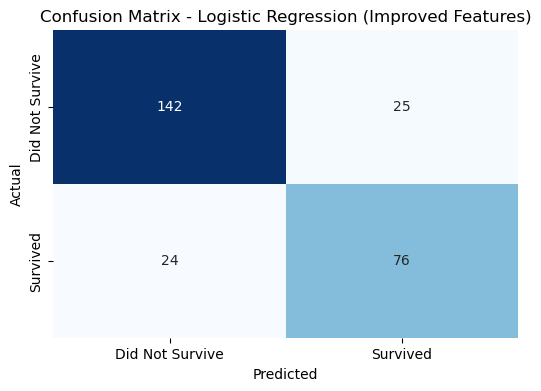

In [8]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Did Not Survive','Survived'],
            yticklabels=['Did Not Survive','Survived'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (Improved Features)")

In [9]:
plt.show()

# Accuracy & Report
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

Accuracy: 0.8164794007490637

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.85       167
           1       0.75      0.76      0.76       100

    accuracy                           0.82       267
   macro avg       0.80      0.81      0.80       267
weighted avg       0.82      0.82      0.82       267



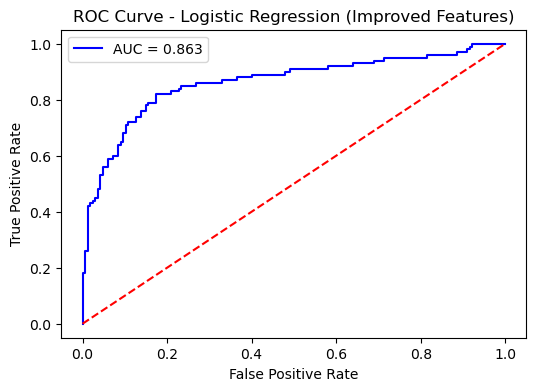

AUC Score: 0.862694610778443


In [10]:
# ROC Curve & AUC
y_probs = logmodel.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], color='red', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Improved Features)")
plt.legend()
plt.show()

print("AUC Score:", auc_score)